2025-03-21 23:01:29, Iteration: 500, Avg MSE: 0.5253974201453093
2025-03-21 23:02:10, Iteration: 1000, Avg MSE: 0.49612397373708517
2025-03-21 23:03:17, Iteration: 1500, Avg MSE: 0.3805453274573665
2025-03-21 23:04:01, Iteration: 2000, Avg MSE: 0.31477631886358726
2025-03-21 23:04:42, Iteration: 2500, Avg MSE: 0.28583613262948343
2025-03-21 23:05:26, Iteration: 3000, Avg MSE: 0.2629908713859913
2025-03-21 23:06:09, Iteration: 3500, Avg MSE: 0.25626737613696604
2025-03-21 23:06:54, Iteration: 4000, Avg MSE: 0.24199394335591934
2025-03-21 23:07:37, Iteration: 4500, Avg MSE: 0.23208664897480047
2025-03-21 23:08:20, Iteration: 5000, Avg MSE: 0.2262519228842575
2025-03-21 23:09:05, Iteration: 5500, Avg MSE: 0.2212968442766578
2025-03-21 23:09:51, Iteration: 6000, Avg MSE: 0.21380309495973052
2025-03-21 23:10:33, Iteration: 6500, Avg MSE: 0.21392605961547814
2025-03-21 23:11:17, Iteration: 7000, Avg MSE: 0.2209407490293961
2025-03-21 23:11:58, Iteration: 7500, Avg MSE: 0.21916533025665558
20

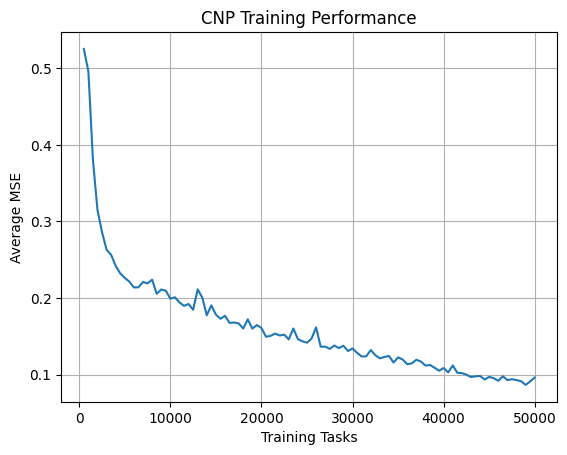

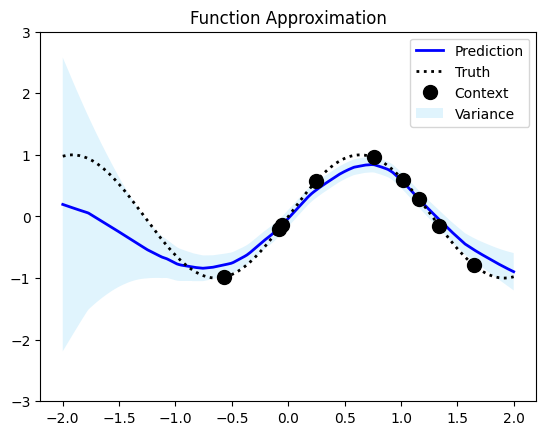

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime
import random

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription", ("query", "target_y")
)

class FunctionFamily:
    SINE = "sine"
    EXP = "exp"
    POLYNOMIAL = "polynomial"
    STRAIGHT_LINE = "straight_line"

class CurvesReader:
    """Generates curves from various function families."""

    def __init__(self, batch_size, max_num_context, testing=False):
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._testing = testing
        self._function_families = [
            FunctionFamily.SINE,
            FunctionFamily.EXP,
            FunctionFamily.POLYNOMIAL,
            FunctionFamily.STRAIGHT_LINE,
        ]

    def generate_curves(self, function_family=None):
        """Builds the op delivering the data."""

        num_context = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))
        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.linspace(start=-2, end=2, steps=num_target).unsqueeze(0).repeat(self._batch_size, 1).unsqueeze(-1)
        else:
            num_target = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))
            num_total_points = num_context + num_target
            x_values = (torch.rand((self._batch_size, num_total_points, 1)) * 4 - 2)  # unif[-2, 2]

        if function_family is None:
            function_family = random.choice(self._function_families)

        if function_family == FunctionFamily.SINE:
            y_values = torch.sin(x_values * (torch.rand(1) * 2 + 0.5))  # Random frequency
        elif function_family == FunctionFamily.EXP:
            y_values = torch.exp(x_values * (torch.rand(1) * 1 - 0.5))  # Random growth/decay
        elif function_family == FunctionFamily.POLYNOMIAL:
            coeffs = torch.rand(3) * 2 - 1  # Quadratic coefficients
            y_values = coeffs[0] + coeffs[1] * x_values + coeffs[2] * x_values**2
        elif function_family == FunctionFamily.STRAIGHT_LINE:
            slope = torch.rand(1) * 2 - 1
            intercept = torch.rand(1) * 2 - 1
            y_values = slope * x_values + intercept
        else:
            raise ValueError(f"Unknown function family: {function_family}")

        if self._testing:
            target_x = x_values
            target_y = y_values
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]
        else:
            target_x = x_values[:, : num_target + num_context, :]
            target_y = y_values[:, : num_target + num_context, :]
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)
        return CNPRegressionDescription(query=query, target_y=target_y)

class DeterministicEncoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicEncoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, context_x, context_y):
        """
        Encode training set as one vector representation
        Args:
            context_x:  batch_size x set_size x feature_dim
            context_y:  batch_size x set_size x 1
        Returns:
            representation:
        """
        encoder_input = torch.cat((context_x, context_y), dim=-1)
        batch_size, set_size, filter_size = encoder_input.shape
        x = encoder_input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        x = x.view(batch_size, set_size, -1)
        representation = x.mean(dim=1)
        return representation

class DeterministicDecoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicDecoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, representation, target_x):
        """
        Take representation representation of current training set, and a target input x,
        return the probability of x being positive
        Args:
            representation: batch_size x representation_size
            target_x: batch_size x set_size x d
        """
        batch_size, set_size, d = target_x.shape
        representation = representation.unsqueeze(1).repeat([1, set_size, 1])
        input = torch.cat((representation, target_x), dim=-1)
        x = input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        out = x.view(batch_size, set_size, -1)
        mu, log_sigma = torch.split(out, 1, dim=-1)
        sigma = 0.1 + 0.9 * torch.nn.functional.softplus(log_sigma)
        dist = torch.distributions.normal.Normal(loc=mu, scale=sigma)
        return dist, mu, sigma

class DeterministicModel(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        super(DeterministicModel, self).__init__()
        self._encoder = DeterministicEncoder(encoder_sizes)
        self._decoder = DeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        (context_x, context_y), target_x = query
        representation = self._encoder(context_x, context_y)
        dist, mu, sigma = self._decoder(representation, target_x)

        log_p = None if target_y is None else dist.log_prob(target_y)
        return log_p, mu, sigma

def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):
    """Plots the predicted mean and variance and the context points."""
    plt.plot(target_x[0].squeeze(), pred_y[0].squeeze(), "b", linewidth=2, label='Prediction')
    plt.plot(target_x[0].squeeze(), target_y[0].squeeze(), "k:", linewidth=2, label='Truth')
    plt.plot(context_x[0].squeeze(), context_y[0].squeeze(), "ko", markersize=10, label='Context')
    plt.fill_between(
        target_x[0].squeeze(),
        (pred_y[0] - var[0]).squeeze(),
        (pred_y[0] + var[0]).squeeze(),
        alpha=0.2,
        facecolor="#65c9f7",
        interpolate=True,
        label='Variance'
    )
    plt.legend()
    plt.ylim([-3, 3])  # Adjust y-axis limits for better visualization
    plt.title('Function Approximation')
    plt.show()

# Hyperparameters
TRAINING_ITERATIONS = int(5e4)
EVAL_AFTER = 500
MAX_CONTEXT_POINTS = 10
BATCH_SIZE = 64
TEST_BATCH_SIZE = 100
NUM_TEST_TASKS = 100

# Fixed test datasets for each function family
fixed_test_datasets = {}
function_families = [
    FunctionFamily.SINE,
    FunctionFamily.EXP,
    FunctionFamily.POLYNOMIAL,
    FunctionFamily.STRAIGHT_LINE,
]
for family in function_families:
    fixed_test_datasets[family] = [
        CurvesReader(TEST_BATCH_SIZE, MAX_CONTEXT_POINTS, testing=True).generate_curves(family)
        for _ in range(NUM_TEST_TASKS)
    ]

# Model and Optimizer
torch.manual_seed(0)
d_x, d_in, representation_size, d_out = 1, 2, 128, 2
encoder_sizes = [d_in, 128, 128, 128, representation_size]
decoder_sizes = [representation_size + d_x, 128, 128, 2]
model = DeterministicModel(encoder_sizes, decoder_sizes)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
mse_values = []
training_tasks = []

def evaluate_mse(model, test_datasets):
    """Evaluates the model on a list of test datasets and returns the average MSE."""
    model.eval()  # Set the model to evaluation mode
    total_mse = 0.0
    with torch.no_grad():  # Disable gradient calculation during evaluation
        for data_test in test_datasets:
            _, pred_y, _ = model(data_test.query, data_test.target_y)
            mse = torch.mean((pred_y - data_test.target_y)**2)
            total_mse += mse.item()
    model.train()  # Set the model back to training mode
    return total_mse / len(test_datasets)

for it in range(TRAINING_ITERATIONS):
    # 1. Randomly choose a function family
    function_family = random.choice(function_families)

    # 2. Generate a training batch from the selected family
    dataset_train = CurvesReader(BATCH_SIZE, MAX_CONTEXT_POINTS, testing=False)
    data_train = dataset_train.generate_curves(function_family)

    # 3. Train the model
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()

    # 4. Evaluate and record MSE
    if (it + 1) % EVAL_AFTER == 0:
        avg_mse = 0.0
        for family in function_families:
            test_datasets = fixed_test_datasets[family]
            avg_mse += evaluate_mse(model, test_datasets)
        avg_mse /= len(function_families)

        mse_values.append(avg_mse)
        training_tasks.append(it + 1)
        print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}, Iteration: {it + 1}, Avg MSE: {avg_mse}")

# Plotting the average MSE
plt.plot(training_tasks, mse_values)
plt.xlabel('Training Tasks')
plt.ylabel('Average MSE')
plt.title('CNP Training Performance')
plt.grid(True)
plt.show()

# Example plotting (optional - plots after training)
dataset_plot = CurvesReader(1, MAX_CONTEXT_POINTS, testing=True)
data_plot = dataset_plot.generate_curves(FunctionFamily.SINE)  # Or any other family
with torch.no_grad():
    _, pred_y, var = model(data_plot.query, data_plot.target_y)
    (context_x, context_y), target_x = data_plot.query
    plot_functions(
        target_x.detach().numpy(),
        data_plot.target_y.detach().numpy(),
        context_x.detach().numpy(),
        context_y.detach().numpy(),
        pred_y.detach().numpy(),
        var.detach().numpy(),
    )
